In [1]:
%%capture
import os, importlib.util
!pip install --upgrade -qqq uv
if importlib.util.find_spec("torch") is None or "COLAB_" in "".join(os.environ.keys()):
    try: import numpy; get_numpy = f"numpy=={numpy.__version__}"
    except: get_numpy = "numpy"
    !uv pip install -qqq \
        "torch>=2.8.0" "triton>=3.4.0" {get_numpy} torchvision bitsandbytes "transformers==4.56.2" trackio \
        "unsloth_zoo[base] @ git+https://github.com/unslothai/unsloth-zoo" \
        "unsloth[base] @ git+https://github.com/unslothai/unsloth" \
        git+https://github.com/triton-lang/triton.git@05b2c186c1b6c9a08375389d5efe9cb4c401c075#subdirectory=python/triton_kernels
elif importlib.util.find_spec("unsloth") is None:
    !uv pip install -qqq unsloth trackio
!uv pip install --upgrade --no-deps transformers==4.56.2 tokenizers trl==0.22.2 unsloth unsloth_zoo

In [2]:
%%capture
!pip install -qqq fastapi uvicorn requests open_spiel
!git clone https://github.com/meta-pytorch/OpenEnv.git > /dev/null 2>&1
%cd OpenEnv
import subprocess, sys, os
from pathlib import Path
sys.path.insert(0, './src')
working_directory = str(Path.cwd().parent.absolute() / "OpenEnv")

In [3]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 768 # Can increase for longer RL output
lora_rank = 4        # Larger rank = smarter, but slower
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/gpt-oss-20b-BF16",
    load_in_4bit = False,
    max_seq_length = max_seq_length,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
#### Unsloth: `hf_xet==1.1.10` and `ipykernel>6.30.1` breaks progress bars. Disabling for now in XET.
#### Unsloth: To re-enable progress bars, please downgrade to `ipykernel==6.30.1` or wait for a fix to
https://github.com/huggingface/xet-core/issues/526
INFO 10-27 21:09:29 [__init__.py:225] Automatically detected platform rocm.
🦥 Unsloth Zoo will now patch everything to make training faster!
Unsloth: AMD currently is not stable with 4bit bitsandbytes. Disabling for now.
Unsloth: AMD currently is not stable with 4bit bitsandbytes. Disabling for now.
==((====))==  Unsloth 2025.10.9: Fast Gpt_Oss patching. Transformers: 4.56.2. vLLM: 0.11.1rc3.dev39+gf417746ad.rocm700.
   \\   /|    . Num GPUs = 1. Max memory: 191.688 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0a0+git1c57644. ROCm Toolkit: 7.0.51831-a3e329ad8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = True]
 "-____-"     Free licens

Loading checkpoint shards:   0%|          | 0/9 [00:00<?, ?it/s]

In [4]:
model = FastLanguageModel.get_peft_model(
    model,
    r = lora_rank, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = [
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ],
    lora_alpha = lora_rank*2, # *2 speeds up training
    use_gradient_checkpointing = "unsloth", # Reduces memory usage
    random_state = 3407,
)

Unsloth: Making `model.base_model.model.model` require gradients


In [5]:
from envs.openspiel_env import OpenSpielEnv
from envs.openspiel_env.models import OpenSpielAction, OpenSpielObservation

In [6]:
import subprocess
import socket
import os
import sys

# --- Find a free port dynamically ---
def find_free_port():
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.bind(("", 0))  # bind to an available port
    port = s.getsockname()[1]
    s.close()
    return port

# --- Setup paths and environment ---
working_directory = os.getcwd()
port = find_free_port()
localhost = f"http://localhost:{port}"
print(f"✅ Launching OpenEnv server at: {localhost}")

# --- Start Uvicorn server subprocess ---
openenv_process = subprocess.Popen(
    [sys.executable, "-m", "uvicorn",
     "envs.openspiel_env.server.app:app",
     "--host", "0.0.0.0",
     "--port", str(port),
     "--log-level", "warning"],  # suppress INFO logs
    env={
        **os.environ,
        "PYTHONPATH": f"{working_directory}/src",
        "OPENSPIEL_GAME": "tic_tac_toe",
        "OPENSPIEL_AGENT_PLAYER": "0",
        "OPENSPIEL_OPPONENT_POLICY": "random"
    },
    stdout=subprocess.PIPE,   # keep stdout if you want to read logs
    stderr=subprocess.PIPE,
    text=True,
    cwd=working_directory
)

import time
import requests

# --- Wait for server startup ---
max_wait = 15  # seconds
server_ready = False

for i in range(max_wait):
    try:
        r = requests.get(localhost)
        if r.status_code in (200, 404):  # either is fine; it’s alive
            server_ready = True
            break
    except requests.exceptions.ConnectionError:
        pass
    time.sleep(1)

if server_ready:
    print(f"🚀 Server successfully started at {localhost}")
else:
    print("❌ Server did not start within timeout.")
    if openenv_process.poll() is not None:
        print("Process exited early.")
        stderr_output = openenv_process.stderr.read()
        print("Error log:\n", stderr_output)


✅ Launching OpenEnv server at: http://localhost:48901
🚀 Server successfully started at http://localhost:48901


In [7]:
import requests
import time
time.sleep(5)
print(requests.get(f"{localhost}/health", timeout = 2).content)
openenv_process = OpenSpielEnv(base_url = localhost)

b'{"status":"healthy"}'


In [8]:
result = openenv_process.reset()
current_state = result.observation
current_state

OpenSpielObservation(done=False, reward=None, metadata={}, info_state=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], legal_actions=[0, 1, 2, 3, 4, 5, 6, 7, 8], game_phase='initial', current_player_id=0, opponent_last_action=None)

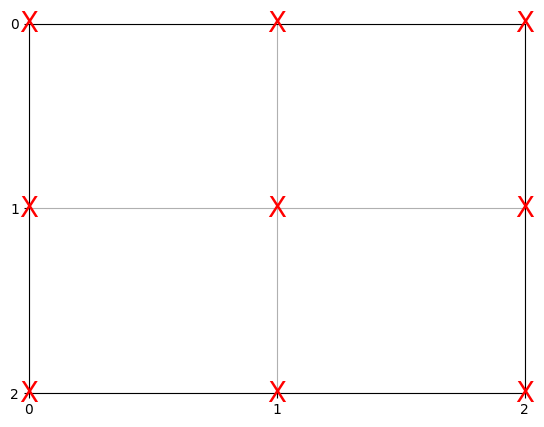

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_tictactoe(info_state):
    x_layer = np.array(info_state[:9])
    o_layer = np.array(info_state[9:18])

    fig, ax = plt.subplots()
    ax.set_xticks(np.arange(3))
    ax.set_yticks(np.arange(3))
    ax.grid(True)

    for i in range(3):
        for j in range(3):
            idx = 3*i + j
            if x_layer[idx] == 1:
                ax.text(j, i, 'X', ha='center', va='center', fontsize=20, color='red')
            elif o_layer[idx] == 1:
                ax.text(j, i, 'O', ha='center', va='center', fontsize=20, color='blue')

    ax.invert_yaxis()
    plt.show()
plot_tictactoe(current_state.info_state)

In [10]:
from typing import Callable

MAX_STEPS = 9  # Tic-Tac-Toe can have at most 9 moves

def _execute_strategy(strategy: Callable, current_state: "OpenSpielObservation"):
    """
    Executes a strategy (callable function) in the Tic-Tac-Toe OpenEnv.
    The strategy receives the current state's info_state (list of 27 floats)
    and returns an integer action (0–8).
    """

    assert callable(strategy), "Strategy must be a callable function"

    steps = 0
    total_reward = 0.0

    while not current_state.done and steps < MAX_STEPS:
        board_state = current_state.info_state  # already a list of floats
        legal_actions = current_state.legal_actions
        try:
            # Strategy must return a valid integer action (0–8)
            action = int(strategy(board_state, legal_actions))
        except Exception:
            total_reward -= 1  # penalize invalid generation
            return steps, total_reward, current_state.done

        # Validate move
        if action not in legal_actions:
            total_reward -= 0.5  # small penalty for illegal move
            return steps, total_reward, current_state.done

        # Perform the move in the environment
        action_obj = OpenSpielAction(action_id=action, game_name="tic_tac_toe")
        result = openenv_process.step(action_obj)
        current_state = result.observation

        # Add any immediate reward
        if result.reward is not None:
            total_reward += result.reward

        steps += 1

        # Stop if the game ended
        if current_state.done:
            break

    return steps, total_reward, current_state.done


def execute_strategy(strategy: Callable, current_state: "OpenSpielObservation"):
    return _execute_strategy(strategy, current_state)


In [11]:
def always_move_left(board_state):
    return "0"

# Reset OpenEnv to an initial state!
result = openenv_process.reset()
current_state = result.observation
try:
    steps, total_reward, is_done = execute_strategy(always_move_left, current_state)
except TimeoutError as e:
    print(f"Timed out with error = {str(e)}")

print(steps, total_reward, is_done)

0 -1.0 False


In [12]:
prompt = """
Create a new short Tic-Tac-Toe strategy using only native Python code.

You are given:
- `info_state`: a Python list of 27 floats representing the 3×3 board as three layers:
  * First 9 → positions occupied by X (the agent)
  * Next 9 → positions occupied by O (the opponent)
  * Last 9 → empty positions
- `legal_actions`: a Python list of integers (0–8) indicating the currently available moves.

Your function must return one valid action ID (integer in string form)
chosen from `legal_actions`.

Each index corresponds to a cell on the 3×3 board in row-major order:
0 1 2
3 4 5
6 7 8

Goal:
- Choose the best possible move to win or block the opponent.
- Never pick an action outside `legal_actions`.

Instructions:
- Use only standard Python libraries (no numpy, etc.)
- Output your short function in backticks using the format below:
```python
def strategy(info_state, legal_actions):
    return "3"  # Example: move right
```
All helper functions should be inside def strategy. Only output the short function `strategy`.
""".strip()

In [13]:
text = tokenizer.apply_chat_template(
    [{"role": "user", "content": prompt}],
    tokenize = False,
    add_generation_prompt = True,
    reasoning_effort = "low",
)

from transformers import TextStreamer
_ = model.generate(
    **tokenizer(text, return_tensors = "pt").to("cuda"),
    temperature = 1.0,
    max_new_tokens = 512,
    streamer = TextStreamer(tokenizer, skip_prompt = False),
)

<|start|>system<|message|>You are ChatGPT, a large language model trained by OpenAI.
Knowledge cutoff: 2024-06
Current date: 2025-10-27

Reasoning: low

# Valid channels: analysis, commentary, final. Channel must be included for every message.
Calls to these tools must go to the commentary channel: 'functions'.<|end|><|start|>user<|message|>Create a new short Tic-Tac-Toe strategy using only native Python code.

You are given:
- `info_state`: a Python list of 27 floats representing the 3×3 board as three layers:
  * First 9 → positions occupied by X (the agent)
  * Next 9 → positions occupied by O (the opponent)
  * Last 9 → empty positions
- `legal_actions`: a Python list of integers (0–8) indicating the currently available moves.

Your function must return one valid action ID (integer in string form)
chosen from `legal_actions`.

Each index corresponds to a cell on the 3×3 board in row-major order:
0 1 2
3 4 5
6 7 8

Goal:
- Choose the best possible move to win or block the opponent.


In [14]:
from unsloth import create_locked_down_function
from unsloth import check_python_modules

In [15]:
def extract_function(text):
    if text.count("```") >= 2:
        first = text.find("```") + 3
        second = text.find("```", first)
        fx = text[first : second].strip()
        fx = fx.removeprefix("python\n")
        fx = fx[fx.find("def"):]
        if fx.startswith("def strategy(info_state, legal_actions):"): return fx
    return None

print(extract_function(prompt))

def strategy(info_state, legal_actions):
    return "3"  # Example: move right


In [16]:
def function_works(completions, **kwargs):
    scores = []
    for completion in completions:
        response = completion[0]["content"]
        function = extract_function(response)

        if function is not None:
            ok, info = check_python_modules(function)
        else:
            ok, info = False, {"error": "no function"}

        if function is None or "error" in info:
            score = -0.5  # invalid or broken
        else:
            try:
                new_strategy = create_locked_down_function(function)
                score = 1.0  # works fine
            except:
                score = 0.0  # syntax okay but fails to build
        scores.append(score)
    return scores


In [17]:
def no_cheating(completions, **kwargs):
    scores = []
    for completion in completions:
        response = completion[0]["content"]
        function = extract_function(response)

        if function is not None:
            ok, info = check_python_modules(function)
            # +1 if clean, -1 if cheating
            scores.append(1.0 if ok else -1.0)
        else:
            # No valid function, slight penalty
            scores.append(-0.5)
    return scores


In [18]:
import os

def reap_zombies():
    try:
        while True:
            pid, _ = os.waitpid(-1, os.WNOHANG)
            if pid == 0:
                break
    except ChildProcessError:
        pass

# Call reap_zombies() periodically in your training loop


In [19]:
def strategy_succeeds(completions, **kwargs):

    scores = []
    reap_zombies()
    for completion in completions:
        response = completion[0]["content"]

        function = extract_function(response)

        if function is not None:
            ok, info = check_python_modules(function)
        else:
            ok, info = False, {"error": "no function"}

        if function is None or "error" in info:
            scores.append(-0.5)
            continue

        try:
            new_strategy = create_locked_down_function(function)
        except:
            scores.append(-0.5)
            continue

        try:
            # Run in OpenEnv
            result = openenv_process.reset()
            current_state = result.observation

            steps, total_reward, completed = execute_strategy(new_strategy, current_state)

            print(f"Steps={steps}, TotalReward={total_reward}")

            if total_reward > 0.5:
                score = 1.0   # Win
            elif total_reward < -0.5:
                score = -1.0  # Loss
            else:
                score = 0.0   # Draw

        except TimeoutError:
            print("Timeout")
            score = -1.0
        except Exception as e:
            print(f"Exception: {str(e)}")
            score = -1.0

        scores.append(score)

    return scores


In [20]:
from datasets import Dataset
dataset = Dataset.from_list([{"prompt" : [{"role": "user", "content": prompt.strip()}], "answer" : 0, "reasoning_effort": "low"}]*1000)
maximum_length = len(tokenizer.apply_chat_template([{"role": "user", "content": prompt.strip()}], add_generation_prompt = True))
print(maximum_length)
dataset[2]

332


{'prompt': [{'content': 'Create a new short Tic-Tac-Toe strategy using only native Python code.\n\nYou are given:\n- `info_state`: a Python list of 27 floats representing the 3×3 board as three layers:\n  * First 9 → positions occupied by X (the agent)\n  * Next 9 → positions occupied by O (the opponent)\n  * Last 9 → empty positions\n- `legal_actions`: a Python list of integers (0–8) indicating the currently available moves.\n\nYour function must return one valid action ID (integer in string form)\nchosen from `legal_actions`.\n\nEach index corresponds to a cell on the 3×3 board in row-major order:\n0 1 2\n3 4 5\n6 7 8\n\nGoal:\n- Choose the best possible move to win or block the opponent.\n- Never pick an action outside `legal_actions`.\n\nInstructions:\n- Use only standard Python libraries (no numpy, etc.)\n- Output your short function in backticks using the format below:\n```python\ndef strategy(info_state, legal_actions):\n    return "3"  # Example: move right\n```\nAll helper fun

In [21]:
%%capture
!pip install trackio

In [22]:
max_prompt_length = maximum_length + 1 # + 1 just in case!
max_completion_length = max_seq_length - max_prompt_length

from trl import GRPOConfig, GRPOTrainer
training_args = GRPOConfig(
    temperature = 1.0,
    learning_rate = 5e-5,
    weight_decay = 0.01,
    warmup_ratio = 0.1,
    lr_scheduler_type = "linear",
    optim = "adamw_8bit",
    logging_steps = 1,
    per_device_train_batch_size = 1,
    gradient_accumulation_steps = 4, # Increase to 4 for smoother training
    num_generations = 2, # Decrease if out of memory
    max_prompt_length = max_prompt_length,
    max_completion_length = max_completion_length,
    # num_train_epochs = 1, # Set to 1 for a full training run
    max_steps = 400,
    save_steps = 50,
    report_to = "trackio", # Can use Weights & Biases, TrackIO
    output_dir = "outputs",

    # For optional training + evaluation
    # fp16_full_eval = True,
    # per_device_eval_batch_size = 4,
    # eval_accumulation_steps = 1,
    # eval_strategy = "steps",
    # eval_steps = 1,
)

Unsloth: We now expect `per_device_train_batch_size` to be a multiple of `num_generations`.
We will change the batch size of 1 to the `num_generations` of 2


In [23]:
# For optional training + evaluation
# new_dataset = dataset.train_test_split(test_size = 0.01)

trainer_tic = GRPOTrainer(
    model = model,
    processing_class = tokenizer,
    reward_funcs = [
        function_works,
        no_cheating,
        strategy_succeeds,
    ],
    args = training_args,
    train_dataset = dataset,

    # For optional training + evaluation
    # train_dataset = new_dataset["train"],
    # eval_dataset = new_dataset["test"],
)

In [24]:
trainer_tic.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': 199998}.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,000 | Num Epochs = 2 | Total steps = 400
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 1,990,656 of 20,916,747,840 (0.01% trained)


* Trackio project initialized: huggingface
* Trackio metrics logged to: /root/.cache/huggingface/trackio


`generation_config` default values have been modified to match model-specific defaults: {'max_length': 131072}. If this is not desired, please set these values explicitly.


* Created new run: jolly-valley-7
Steps=0, TotalReward=-1.0
Steps=4, TotalReward=1.0
Steps=3, TotalReward=-1.0
Steps=1, TotalReward=-0.5
Steps=4, TotalReward=1.0
Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,reward,reward_std,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,sampling / sampling_logp_difference / mean,sampling / sampling_logp_difference / max,sampling / importance_sampling_ratio / min,sampling / importance_sampling_ratio / mean,sampling / importance_sampling_ratio / max,kl,rewards / function_works / mean,rewards / function_works / std,rewards / no_cheating / mean,rewards / no_cheating / std,rewards / strategy_succeeds / mean,rewards / strategy_succeeds / std
1,0.000000,0.687500,2.209709,408.750000,373.000000,435.000000,0.500000,382.500000,373.000000,407.000000,0,0,0,0,0,0.003223,0.437500,0.776324,0.437500,0.776324,-0.187500,0.798995
2,0.000000,0.625000,1.414214,369.375000,274.000000,435.000000,0.500000,303.750000,274.000000,323.000000,No Log,No Log,No Log,No Log,No Log,0.004718,0.250000,0.801784,0.250000,0.801784,0.125000,0.744024
3,0.000000,1.062500,2.032932,384.500000,224.000000,435.000000,0.375000,354.200012,224.000000,434.000000,No Log,No Log,No Log,No Log,No Log,0.002744,0.437500,0.776324,0.437500,0.776324,0.187500,0.883884
4,0.000000,-0.937500,0.795495,429.125000,388.000000,435.000000,0.875000,388.000000,388.000000,388.000000,No Log,No Log,No Log,No Log,No Log,0.001197,-0.312500,0.530330,-0.312500,0.530330,-0.312500,0.530330
5,0.000000,0.250000,1.590990,419.625000,379.000000,435.000000,0.500000,404.250000,379.000000,426.000000,No Log,No Log,No Log,No Log,No Log,0.001521,0.250000,0.801784,0.250000,0.801784,-0.250000,0.801784
6,0.000000,1.312500,2.386486,405.250000,359.000000,435.000000,0.375000,387.399994,359.000000,428.000000,No Log,No Log,No Log,No Log,No Log,0.003420,0.437500,0.776324,0.437500,0.776324,0.437500,0.776324
7,0.000000,-0.062500,2.032932,416.125000,365.000000,435.000000,0.625000,384.666687,365.000000,415.000000,No Log,No Log,No Log,No Log,No Log,0.002323,0.062500,0.776324,0.062500,0.776324,-0.187500,0.752970
8,0.000000,1.625000,1.237437,404.500000,308.000000,435.000000,0.250000,394.333344,308.000000,418.000000,No Log,No Log,No Log,No Log,No Log,0.002342,0.625000,0.694365,0.625000,0.694365,0.375000,0.876275
9,0.000000,0.250000,1.590990,412.875000,378.000000,435.000000,0.500000,390.750000,378.000000,407.000000,No Log,No Log,No Log,No Log,No Log,0.002017,0.250000,0.801784,0.250000,0.801784,-0.250000,0.801784
10,0.000000,0.625000,3.005204,419.125000,359.000000,435.000000,0.500000,403.250000,359.000000,435.000000,No Log,No Log,No Log,No Log,No Log,0.002130,0.250000,0.801784,0.250000,0.801784,0.125000,0.744024


Steps=5, TotalReward=0.0
Steps=3, TotalReward=1.0
Steps=3, TotalReward=1.0
Steps=4, TotalReward=1.0
Steps=1, TotalReward=-1.0
Steps=4, TotalReward=1.0
Steps=3, TotalReward=1.0
Steps=4, TotalReward=1.0
Steps=3, TotalReward=1.0
Steps=3, TotalReward=1.0
Steps=3, TotalReward=1.0
Steps=3, TotalReward=-1.0
Steps=4, TotalReward=1.0
Steps=4, TotalReward=-1.0
Steps=4, TotalReward=1.0
Steps=4, TotalReward=1.0
Steps=3, TotalReward=1.0
Steps=4, TotalReward=1.0
Steps=3, TotalReward=1.0
Steps=4, TotalReward=1.0
Steps=0, TotalReward=-1.0
Steps=3, TotalReward=1.0
Steps=4, TotalReward=1.0
Steps=4, TotalReward=1.0
Steps=3, TotalReward=1.0
Steps=3, TotalReward=-1.0
Steps=3, TotalReward=1.0
Steps=4, TotalReward=1.0
Steps=3, TotalReward=1.0
Steps=0, TotalReward=-1.0
Steps=4, TotalReward=-1.0
Steps=3, TotalReward=1.0
Steps=4, TotalReward=1.0
Steps=1, TotalReward=-0.5
Steps=5, TotalReward=1.0
Steps=3, TotalReward=1.0
Steps=1, TotalReward=-0.5
Steps=4, TotalReward=1.0
Steps=3, TotalReward=-1.0
Steps=3, TotalR

TrainOutput(global_step=400, training_loss=0.0028148016734940028, metrics={'train_runtime': 9019.621, 'train_samples_per_second': 0.355, 'train_steps_per_second': 0.044, 'total_flos': 0.0, 'train_loss': 0.0028148016734940028})

In [25]:
text = tokenizer.apply_chat_template(
    [{"role": "user", "content": prompt}],
    tokenize = False,
    add_generation_prompt = True,
    reasoning_effort = "low",
)

output = model.generate(
    **tokenizer(text, return_tensors="pt").to("cuda"),
    temperature=1.0,
    max_new_tokens=1024,
)
response = tokenizer.decode(output[0], skip_special_tokens=True)
print(response)

systemYou are ChatGPT, a large language model trained by OpenAI.
Knowledge cutoff: 2024-06
Current date: 2025-10-27

Reasoning: low

# Valid channels: analysis, commentary, final. Channel must be included for every message.
Calls to these tools must go to the commentary channel: 'functions'.userCreate a new short Tic-Tac-Toe strategy using only native Python code.

You are given:
- `info_state`: a Python list of 27 floats representing the 3×3 board as three layers:
  * First 9 → positions occupied by X (the agent)
  * Next 9 → positions occupied by O (the opponent)
  * Last 9 → empty positions
- `legal_actions`: a Python list of integers (0–8) indicating the currently available moves.

Your function must return one valid action ID (integer in string form)
chosen from `legal_actions`.

Each index corresponds to a cell on the 3×3 board in row-major order:
0 1 2
3 4 5
6 7 8

Goal:
- Choose the best possible move to win or block the opponent.
- Never pick an action outside `legal_actions`.

In [26]:
model.save_pretrained_merged(
    save_directory = "finetuned_model",
    tokenizer = tokenizer,
    save_method = "bf16",   # or "fp16" if you want smaller files
)


Unsloth: Found MXFP4 variant = `unsloth/gpt-oss-20b`
Found HuggingFace hub cache directory: /root/.cache/huggingface/hub
Checking cache directory for required files...
Cache check failed: model-00000-of-00002.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.
Checking cache directory for required files...
Cache check failed: tokenizer.model not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Preparing safetensor model files: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.09s/it]


Note: tokenizer.model not found (this is OK for non-SentencePiece models)


Unsloth: Merging weights into mxfp4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.02s/it]


Unsloth: Merge process complete. Saved to `/workspace/OpenEnv/finetuned_model`


In [27]:
from transformers import AutoModelForCausalLM, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("finetuned_model")
model = AutoModelForCausalLM.from_pretrained("finetuned_model", torch_dtype=torch.bfloat16, device_map="auto")


ValueError: not enough values to unpack (expected 4, got 3)

In [ ]:
model.save_pretrained("lora_finetuned_model")
tokenizer.save_pretrained("lora_finetuned_model")
from unsloth import FastLanguageModel

base_model, tokenizer = FastLanguageModel.from_pretrained(
    "unsloth/gpt-oss-20b-BF16",
    max_seq_length = 768,
    load_in_4bit = False,
)

model = FastLanguageModel.get_peft_model(base_model)
model.load_adapter("lora_finetuned_model")
